In [296]:
import os
import sys
sys.path.append("./..")
from utils import PROJECT_ROOT
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import networkx as nx
from matplotlib.lines import Line2D
import pandas as pd
from c_Population_graph.population_graph import construct_PopulationGraph
from c_Population_graph.community_detection import detect_communities
from e_Survival_analysis.survival_analysis import calculate_hazard_ratio
from lifelines import CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test, logrank_test

In [306]:
iteration = 2
PhenoGraph_k =  30
size_smallest_cluster = 20
survival_type = 'Overall'
Pattern_id_to_validate = [17]
# 24 11.0 0.0
# 29 1.0 0.0
# 39 12.0 0.0
# 47 7.0 0.0
# 20 15.0 0.0]

In [307]:
SoftWL_dict= pickle.load(
    open(
        os.path.join(
            PROJECT_ROOT,
            "Output",
            "b_Soft_WL_Kernel",
            "Danenberg",
            "Cohort_2",
            "Matched_SoftWL_dict_iter_"
            + str(iteration)
            + "_PhenoGraph_k_"
            + str(PhenoGraph_k)
            + ".pkl",
        ),
        "rb",
    ),
)
Patient_IDs = SoftWL_dict["Patient_id"]
Histograms = SoftWL_dict["Histogram"]
clinical = pd.read_csv(
    os.path.join(
        PROJECT_ROOT,
        "Input",
        "Clinical",
        "Danenberg",
        "clinical.csv",
    )
)
clinical['Overall Survival Status'] = clinical['Overall Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})
clinical['Relapse Free Status'] = clinical['Relapse Free Status'].map({'0:Not Recurred':0, '1:Recurred':1})
clinical['Disease-specific Survival Status'] = clinical['Disease-specific Survival Status'].map({'0:LIVING':0, '1:DECEASED':1})

In [308]:
if survival_type == 'Overall':
    Length = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival (Months)'].values[0] for i in Patient_IDs]
    Status = [clinical.loc[clinical['patient_id'] == i, 'Overall Survival Status'].values[0] for i in Patient_IDs]  
elif survival_type == 'Relpase-free':
    Length = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status (Months)'].values[0] for i in Patient_IDs]
    Status = [clinical.loc[clinical['patient_id'] == i, 'Relapse Free Status'].values[0] for i in Patient_IDs] 
elif survival_type == 'Disease-specific':
    Length = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival (Months)'].values[0] for i in Patient_IDs]
    Status = [clinical.loc[clinical['patient_id'] == i, 'Disease-specific Survival Status'].values[0] for i in Patient_IDs]
DF = pd.DataFrame({"Length": Length, "Status": Status}).dropna()
Length_ = np.array(DF["Length"])
Status_ = np.array(DF["Status"])
Histograms_ = Histograms[DF.index.values, :]
Patient_IDs_ = np.array(Patient_IDs)[DF.index.values]

17 0 0


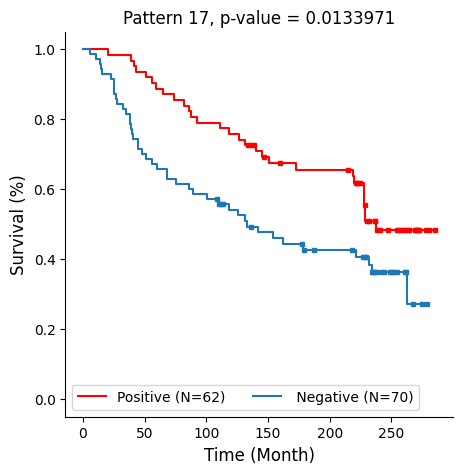

In [309]:

color_palette = ["white"] + sns.color_palette("tab10") + sns.color_palette("Set2")
for pattern_id in Pattern_id_to_validate:
    histogram_pattern = Histograms_[:, pattern_id]
    # print(
    #     "min = {}, max = {}, 25-percentile = {}, 50 percentile = {}, 90 percentile = {}".format(
    #         np.min(histogram_pattern),
    #         np.max(histogram_pattern),
    #         np.percentile(histogram_pattern, 25),
    #         np.percentile(histogram_pattern, 50),
    #         np.percentile(histogram_pattern, 90),
    #     )
    # )
    high_threshold =0
    low_threshold = 0
    print(pattern_id, high_threshold, low_threshold)
    kmf = KaplanMeierFitter()
    length_A, event_observed_A = (
        Length_[histogram_pattern > high_threshold],
        Status_[histogram_pattern > high_threshold],
    )
    length_B, event_observed_B = (
        Length_[histogram_pattern <= low_threshold],
        Status_[histogram_pattern <= low_threshold],
    )
    length_C, event_observed_C = (
        Length_[
            (histogram_pattern > low_threshold) & (histogram_pattern < high_threshold)
        ],
        Status_[
            (histogram_pattern > low_threshold) & (histogram_pattern < high_threshold)
        ],
    )
    log_rank_test = multivariate_logrank_test(
        np.concatenate([length_A, length_B]),
        [0] * len(length_A) + [1] * len(length_B) ,
        np.concatenate([event_observed_A, event_observed_B]),
    )
    p_value = log_rank_test.p_value
    if p_value: #< 0.05/len(Pattern_id_to_validate):
        f, ax = plt.subplots(figsize=(5, 5))
        kmf.fit(length_A, event_observed_A, label="Positive (N={})".format(len(length_A)))
        kmf.plot_survival_function(
            ax=ax,
            ci_show=False,
            color="red",
            show_censors=True,
            censor_styles={"ms": 3, "marker": "s"},
        )

        kmf.fit(length_B, event_observed_B, label=" Negative (N={})".format(len(length_B)))
        kmf.plot_survival_function(
            ax=ax,
            ci_show=False,
            color=color_palette[1],
            show_censors=True,
            censor_styles={"ms": 3, "marker": "s"},
        )
        # kmf.fit(length_C, event_observed_C, label="Low (N={})".format(len(length_C)))
        # kmf.plot_survival_function(
        #     ax=ax,
        #     ci_show=False,
        #     color=color_palette[3],
        #     show_censors=True,
        #     censor_styles={"ms": 3, "marker": "s"},
        # )
        ax.legend(ncol=2, fontsize=10)
        ax.set_title("Pattern {}, p-value = {:.7f}".format(pattern_id, p_value), fontsize=12)
        ax.set_xlabel("Time (Month)", fontsize=12)
        ax.set_ylabel("Survival (%)", fontsize=12)
        ax.set(
                ylim=(-0.05, 1.05),
            )
        sns.despine()

In [301]:
# Histograms_ = (Histograms_ - np.mean(Histograms_, axis=0))/np.std(Histograms_, axis=0)
DF = pd.DataFrame({
    'length': Length_,
    'status': Status_,
})
for pattern_id in Pattern_id_to_validate:
    DF["pattern_"+str(pattern_id)] = Histograms_[:, pattern_id]
cph = CoxPHFitter()
cph.fit(DF, duration_col='length', event_col='status', formula=" + ".join(["pattern_"+str(i) for i in Pattern_id_to_validate]))
print(cph.print_summary())

<lifelines.CoxPHFitter: fitted with 132 total observations, 60 right-censored observations>
             duration col = 'length'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 132
number of events observed = 72
   partial log-likelihood = -310.34
         time fit was run = 2023-11-03 01:31:09 UTC

---
             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                          
pattern_11  -0.02       0.98       0.01            -0.04             0.00                 0.96                 1.00
pattern_13   0.04       1.04       0.02            -0.01             0.08                 0.99                 1.08
pattern_21   0.00       1.00       0.04            -0.08             0.08                 0.92                 1.09
pattern_24   0.01       1.01       0.00             0.00             0.02                 1.00                 1.02
pattern_25   0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
pattern_26  -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
pattern_28   0.00       1.00       0.02            -0.03             0.03                 0.97                 1.03
pattern_30  -0.07       0.93       0.03            -0.12            -0.02                 0.89                 0.98
pattern_4    0.00       1.00       0.00            -0.00             0.01                 1.00                 1.01
pattern_44   0.05       1.05       0.04            -0.02             0.13                 0.98                 1.14
pattern_71  -0.01       0.99       0.01            -0.02             0.00                 0.98                 1.00
pattern_76  -0.02       0.98       0.03            -0.09             0.04                 0.92                 1.04
pattern_78   0.16       1.18       0.10            -0.04             0.36                 0.96                 1.44
pattern_96  -0.31       0.73       0.20            -0.70             0.07                 0.50                 1.07

             cmp to     z      p   -log2(p)
covariate                                  
pattern_11     0.00 -1.83   0.07       3.90
pattern_13     0.00  1.65   0.10       3.34
pattern_21     0.00  0.03   0.97       0.04
pattern_24     0.00  2.99 <0.005       8.49
pattern_25     0.00  0.02   0.98       0.02
pattern_26     0.00 -0.46   0.65       0.63
pattern_28     0.00  0.17   0.86       0.21
pattern_30     0.00 -2.61   0.01       6.78
pattern_4      0.00  0.54   0.59       0.76
pattern_44     0.00  1.35   0.18       2.49
pattern_71     0.00 -1.05   0.29       1.77
pattern_76     0.00 -0.70   0.48       1.05
pattern_78     0.00  1.59   0.11       3.17
pattern_96     0.00 -1.60   0.11       3.20
---
Concordance = 0.62
Partial AIC = 648.68
log-likelihood ratio test = 19.71 on 14 df
-log2(p) of ll-ratio test = 2.84

None
